In [1]:
import pandas as pd
import numpy as np
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from tqdm import tqdm
from tensorflow import keras
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
import warnings
warnings.filterwarnings('ignore')

In [28]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

In [4]:
filenames=os.listdir("./dogs-vs-cats/train/train/")
categories=[]
binary_labels = []
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append('dog')
        binary_labels.append(1) #Label dog by 1
    else:
        categories.append('cat') #Label cat by 0
        binary_labels.append(0)
train_df= pd.DataFrame({
    'filename':filenames,
    'category':categories,
    'binay_labels':binary_labels
})

In [5]:
train_df.head()

,filename,category,binay_labels
0,cat.0.jpg,cat,0
1,cat.1.jpg,cat,0
2,cat.10.jpg,cat,0
3,cat.100.jpg,cat,0
4,cat.1000.jpg,cat,0


In [6]:
train_set, validation_set = train_test_split(train_df,
                                     test_size=0.1)
print(len(train_set), len(validation_set))

22500 2500


(-0.5, 299.5, 279.5, -0.5)

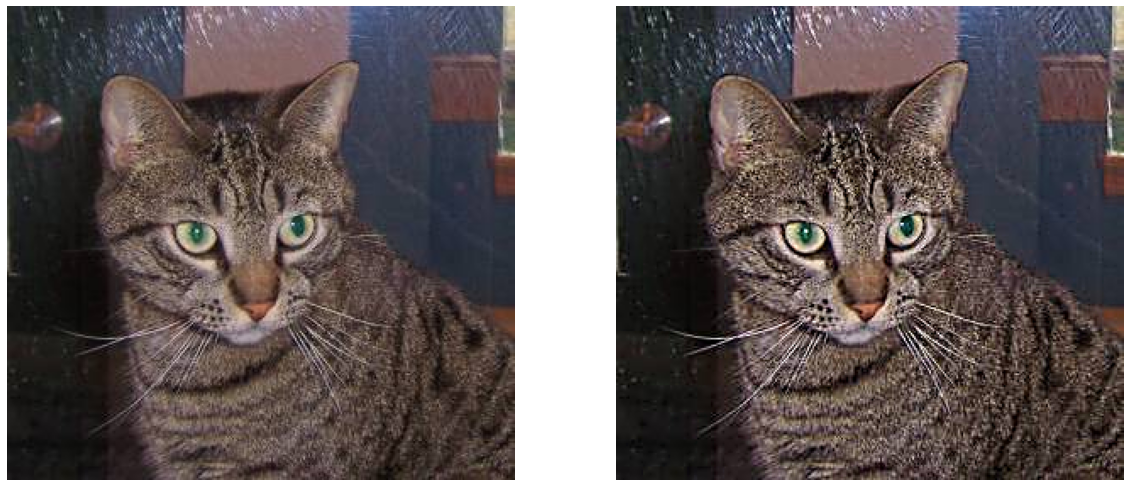

In [11]:
filepath = './dogs-vs-cats/train/train/'
img = PIL.Image.open(filepath + os.listdir(filepath)[1])
img_new = img.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=80))
fig = plt.figure(1, figsize = (20, 20))
plt.subplot(2,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(img_new)
plt.axis('off')

In [12]:
for i in tqdm(range(len(os.listdir(filepath)))):
        pic_path = filepath + os.listdir(filepath)[i]
        pic = PIL.Image.open(pic_path)
        pic_sharp = pic.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=100))
        pic_sharp.save(pic_path)

100%|██████████| 25000/25000 [22:48<00:00, 18.27it/s]


In [13]:
print(pic_path)

./dogs-vs-cats/train/train/dog.9999.jpg


In [16]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
batch_size = 128
destination = './dogs-vs-cats/train'

train_generator = train_gen.flow_from_dataframe(
    dataframe = train_set,
    directory = destination + '/train/',
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size
)


validation_generator = val_gen.flow_from_dataframe(
    dataframe = validation_set,
    directory = destination + '/train/',
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size,
    shuffle = False
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [17]:
from keras.models import Sequential
data_augmentation = keras.Sequential(
  [ layers.RandomFlip("horizontal",input_shape=(224,224,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [19]:
input_shape = (224, 224, 3)
n_class = 2
model = Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation = 'softmax')
])

In [20]:
model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 64)      36928     
                                                      

In [23]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 3,
    verbose = 1,
    mode = "min")

checkpoint = ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True, 
    save_weights_only = True
)

In [26]:
with tf.device('/device:GPU:0'):
    epochs=40
    history = model.fit_generator(train_generator, 
                            validation_data=validation_generator, 
                            epochs=epochs,
                            validation_steps = validation_set.shape[0] // batch_size,
                            steps_per_epoch = train_set.shape[0] // batch_size, callbacks = [early_stopping])

Epoch 1/40
175/175 [==============================] - 2036s 12s/step - loss: 0.6930 - accuracy: 0.5076 - val_loss: 0.6932 - val_accuracy: 0.5008
Epoch 2/40
175/175 [==============================] - 2007s 11s/step - loss: 0.6880 - accuracy: 0.5280 - val_loss: 0.6723 - val_accuracy: 0.5814
Epoch 3/40
175/175 [==============================] - 1844s 11s/step - loss: 0.6650 - accuracy: 0.5925 - val_loss: 0.6400 - val_accuracy: 0.6476
Epoch 4/40
175/175 [==============================] - 1892s 11s/step - loss: 0.6376 - accuracy: 0.6408 - val_loss: 0.6197 - val_accuracy: 0.6682
Epoch 5/40
175/175 [==============================] - 1820s 10s/step - loss: 0.6292 - accuracy: 0.6579 - val_loss: 0.6107 - val_accuracy: 0.6579
Epoch 6/40
175/175 [==============================] - 1941s 11s/step - loss: 0.5987 - accuracy: 0.6841 - val_loss: 0.5810 - val_accuracy: 0.6994
Epoch 7/40
175/175 [==============================] - 1836s 10s/step - loss: 0.5744 - accuracy: 0.7032 - val_loss: 0.5416 - val_ac

In [27]:
model.save("model1_catsVSdogs_94.h5")

Last train accuracy: 0.925800085067749
Last validation accuracy: 0.9169408082962036


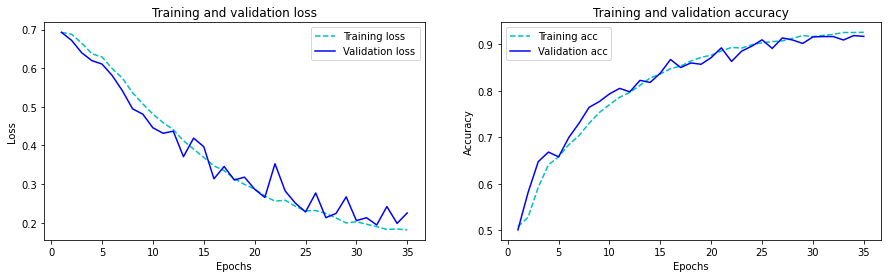

In [29]:
show_result(history)